<a href="https://colab.research.google.com/github/dv0310/-Dilip-Vatnala_INFO5731_Fall2023/blob/main/INFO5731_Group_1_term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ignore future or other warnings
import warnings
warnings.filterwarnings("ignore")

# Importing Pandas and other needed libraries for this block
import pandas as pd
import os
import zipfile

# Loading our dataset excel files
data_df = pd.read_excel('DATA_US_cleanVersion_updated_Nov20.xlsx')
codebook_df = pd.read_excel('Codebook_MisInfoPolicyAnalysis_US2020-21.xlsx')
relevant_coding_df = pd.read_excel('US_relevant_coding.xlsx')

# Unzipping and loading all text files from USData_B1-B447.zip dataset folder
with zipfile.ZipFile('USData_B1-B447.zip', 'r') as zip_ref:
    zip_ref.extractall('USData_B1-B447')

text_data_path = 'USData_B1-B447/USData_B1-B447'
text_files = os.listdir(text_data_path)
text_data = {file.split('.')[0]: open(os.path.join(text_data_path, file), 'r').read() for file in text_files}

In [ ]:
# Map text data to the main dataframe using 'ID'
data_df['Document_Text'] = data_df['ID'].apply(lambda x: text_data.get(x))

# Create a mapping function for codebook and relevant coding
def map_codebook_and_coding(doc_id, codebook, coding):
    # Extracting the relevant coding row for the document
    coding_info = coding[coding['Unnamed: 0'] == doc_id]
    if coding_info.empty:
        return []

    # Finding columns in the coding dataframe that are not 'Unnamed: 0' and have a non-null value for the row
    relevant_columns = [col for col in coding.columns if col != 'Unnamed: 0' and not pd.isna(coding_info[col].values[0])]
    codebook_info = codebook[codebook['Name'].isin(relevant_columns)]
    return codebook_info['Description'].tolist()

# Applying the mapping to the main dataset's dataframe
data_df['Categorized_Info'] = data_df['ID'].apply(lambda x: map_codebook_and_coding(x, codebook_df, relevant_coding_df))

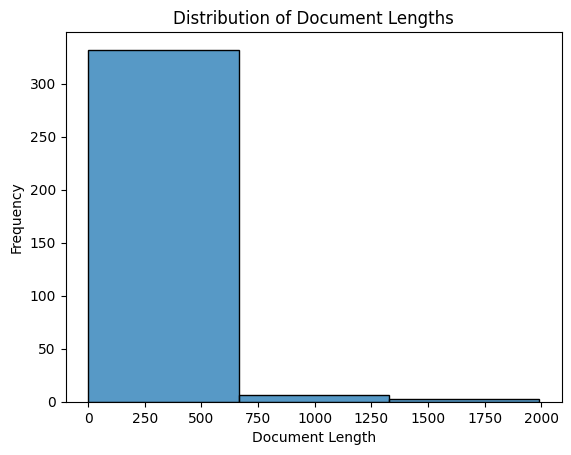

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exploring Document Lengths
data_df['Doc_Length'] = data_df['Document_Text'].apply(lambda x: len(x.split()) if x is not None else 0)

# Plotting the histogram
sns.histplot(data_df['Doc_Length'], bins=3)
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

# data_df.head(1)

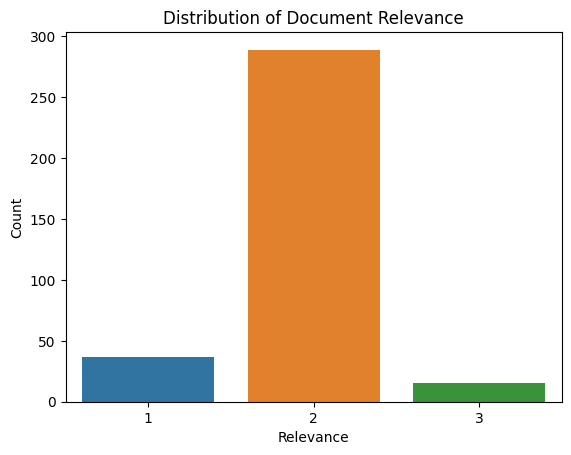

In [ ]:
# Exploring 'Relevance' Column
sns.countplot(x='RELEVANCE', data=data_df)
plt.title('Distribution of Document Relevance')
plt.xlabel('Relevance')
plt.ylabel('Count')
plt.show()

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Check if text is not None before processing
    if text is not None:
        # Tokenization, Lemmatization, and Stop Word Removal
        tokens = [lemmatizer.lemmatize(word) for word in text.split() if word.lower() not in stop_words]
        return ' '.join(tokens)
    else:
        return ''  # Return an empty string for None entries

data_df['Processed_Text'] = data_df['Document_Text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

def advanced_text_processing(text):
  # Check if text is not None before processing
  if text is not None:
    sentences = sent_tokenize(text)
    word_tokens = [word_tokenize(sentence) for sentence in sentences]
    return word_tokens

  return ''

data_df['Advanced_Processed_Text'] = data_df['Processed_Text'].apply(advanced_text_processing)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


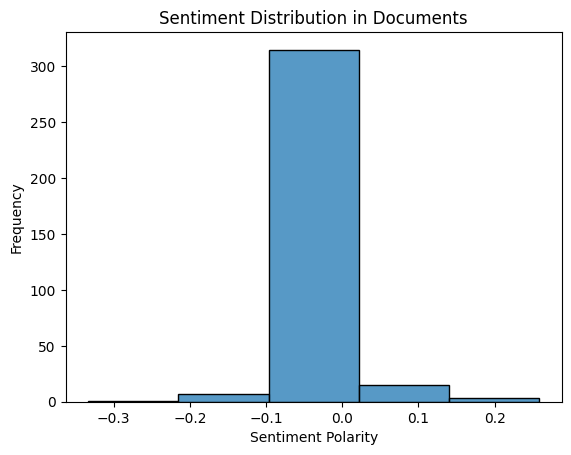

In [ ]:
from textblob import TextBlob

# Function to calculate sentiment
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis
data_df['Sentiment'] = data_df['Processed_Text'].apply(calculate_sentiment)

# Plotting sentiment distribution
sns.histplot(data_df['Sentiment'], bins=5)
plt.title('Sentiment Distribution in Documents')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Initializing BERT Tokenizer and Model to generate the embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to BERT encode text
def bert_encode(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

In [ ]:
# Removing rows without text data
filtered_data = data_df[data_df['Processed_Text'].notna()]

# Generating BERT embeddings for each row or document
embeddings = [bert_encode(text) for text in filtered_data['Processed_Text']]

In [ ]:
import spacy
from spacy import displacy

# Load Spacy NER model
nlp = spacy.load("en_core_web_sm")

# Sample document for NER visualization
sample_doc = nlp(filtered_data['Processed_Text'].iloc[0])

# Visualizing entities in the sample document
displacy.render(sample_doc, style='ent', jupyter=True)

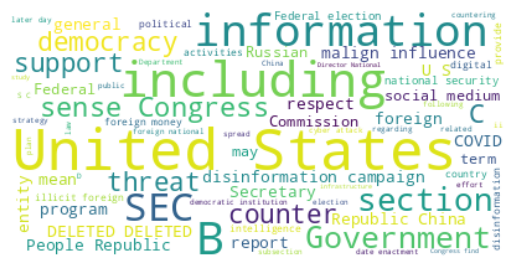

In [ ]:
from wordcloud import WordCloud

# Generating a word cloud
wc_text = ' '.join(data_df['Processed_Text'].tolist())
wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue')
wordcloud.generate(wc_text)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

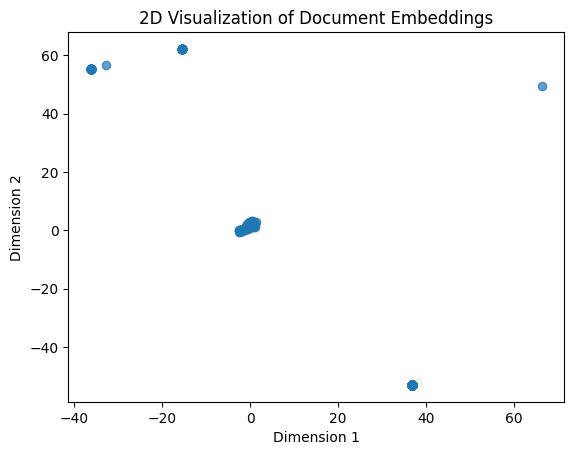

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

embeddings_list= [np.array(embed) for embed in embeddings]
embeddings_array = np.vstack(embeddings_list)

# Reducing dimensions of embeddings for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Plotting
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.title('2D Visualization of Document Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# TF-IDF and KMeans for document categorization
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_data['Processed_Text'])

kmeans = KMeans(n_clusters=5)
categories = kmeans.fit_predict(tfidf_matrix)
filtered_data['Category'] = categories

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display top words per topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, tfidf_vectorizer.get_feature_names_out(), 10)

Topic 0:
georgia submit law timely provision awareness seek communication combat individual
Topic 1:
spread misinformation covid 19 information seek network right individual 2020
Topic 2:
information chinese campaign vaccine election shall section party health communist
Topic 3:
states united including disinformation russian intelligence foreign security national government
Topic 4:
community biodefense hpv biological risks veterans seek misinformation rights network


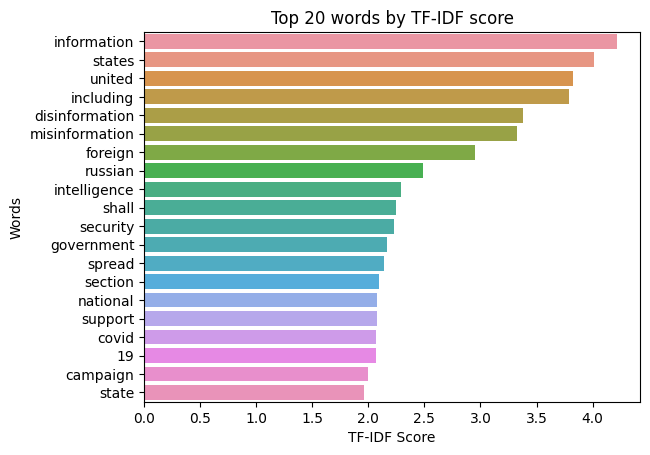

In [ ]:
# Summarizing the TF-IDF Scores
sum_tfidf = tfidf_matrix.sum(axis=0)
tfidf_scores = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

# Plotting Top 20 Words
top_n_words = tfidf_scores[:20]
sns.barplot(x=[score for word, score in top_n_words], y=[word for word, score in top_n_words])
plt.title('Top 20 words by TF-IDF score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

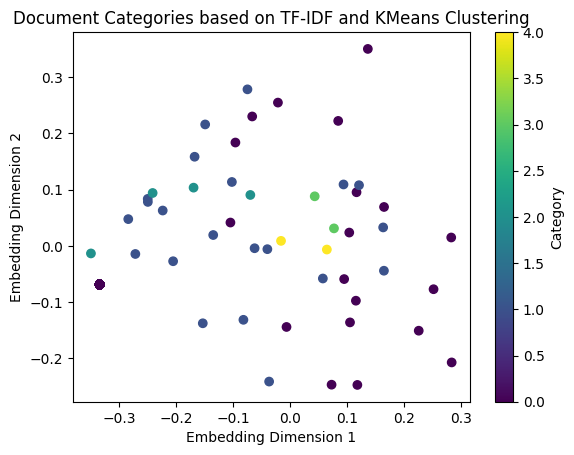


Category 0 sample documents:
 - Open Hearing: Worldwide Threat Assessment of the U.S. Intelligence Community
 - The Afghanistan Papers: Costs and Benefits of America's Longest War
 - Remarks on Signing an Executive Order on the America First Health Care Plan in Charlotte, North Carolina
 - Continuation of the National Emergency With Respect to Foreign Interference in or Undermining Public Confidence in United States Elections
 - PROVIDING FOR CONSIDERATION OF THE BILL (H.R. 6395) TO AUTHORIZE APPROPRIATIONS FOR FISCAL YEAR 2021 FOR MILITARY ACTIVITIES OF THE DEPARTMENT OF DEFENSE AND FOR MILITARY CONSTRUCTION, TO PRESCRIBE MILITARY PERSONNEL STRENGTHS FOR SUCH FISCAL YEAR, AND FOR OTHER PURPOSES; PROVIDING FOR CONSIDERATION OF THE BILL (H.R. 7027) MAKING ADDITIONAL SUPPLEMENTAL APPROPRIATIONS FOR DISASTER RELIEF REQUIREMENTS FOR THE FISCAL YEAR ENDING SEPTEMBER 30, 2020, AND FOR OTHER PURPOSES; PROVIDING FOR CONSIDERATION OF THE BILL (H.R. 7327) MAKING ADDITIONAL SUPPLEMENTAL APPROPRI

In [ ]:
import numpy as np

# Convert list of embeddings to a 2D NumPy array
embeddings_array = np.array(embeddings)

# Plotting the document categories
plt.scatter(embeddings_array[:, 0], embeddings_array[:, 1], c=filtered_data['Category'], cmap='viridis')
plt.title('Document Categories based on TF-IDF and KMeans Clustering')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.colorbar(label='Category')
plt.show()

# Summary of categories
for category in set(categories):
    print(f"\nCategory {category} sample documents:")
    num_docs = len(filtered_data[filtered_data['Category'] == category])
    sample_docs = filtered_data[filtered_data['Category'] == category]['TITLE'].sample(min(num_docs, 5)).tolist()
    for doc in sample_docs:
        print(f" - {doc}")

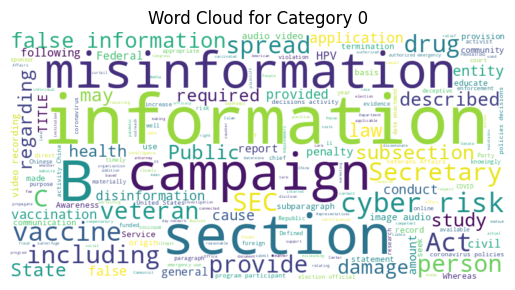

In [ ]:
from wordcloud import WordCloud

# Category Word Cloud
category_index = 0
specific_category_text = ' '.join(filtered_data[filtered_data['Category'] == category_index]['Processed_Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(specific_category_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud for Category {category_index}')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from collections import Counter

# Count the number of instances per class
class_counts = Counter(y_labels)

# Find classes with only one instance
classes_to_remove = [class_label for class_label, count in class_counts.items() if count == 1]

# Filter out these classes
filtered_data = filtered_data[~filtered_data['Category'].isin(classes_to_remove)]

# Update X_features and y_labels after filtering
X_features = tfidf_vectorizer.fit_transform(filtered_data['Processed_Text'])
y_labels = filtered_data['Category']

# Proceed with the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, stratify=y_labels, random_state=42)

# Using Multiple Models for classification
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Naive Bayes": MultinomialNB()
}

Random Forest Accuracy: 0.9705882352941176
Random Forest Precision: 0.9897435897435898
Random Forest Recall: 0.8333333333333334
Random Forest F1 Score: 0.8836805555555555

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        63
           1       1.00      0.50      0.67         4
           2       1.00      1.00      1.00         1

    accuracy                           0.97        68
   macro avg       0.99      0.83      0.88        68
weighted avg       0.97      0.97      0.97        68



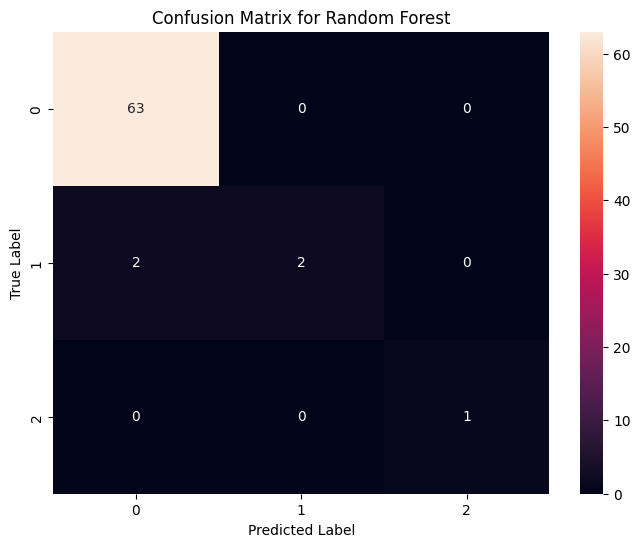

Support Vector Machine Accuracy: 0.9264705882352942
Support Vector Machine Precision: 0.3088235294117647
Support Vector Machine Recall: 0.3333333333333333
Support Vector Machine F1 Score: 0.3206106870229008

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        63
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         1

    accuracy                           0.93        68
   macro avg       0.31      0.33      0.32        68
weighted avg       0.86      0.93      0.89        68



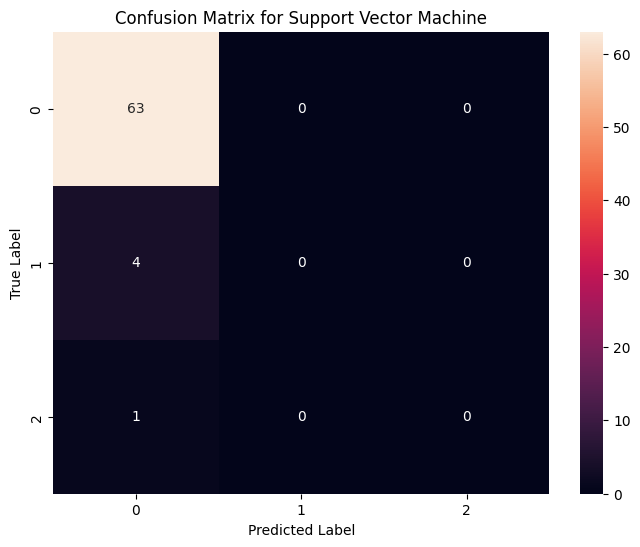

Naive Bayes Accuracy: 0.9264705882352942
Naive Bayes Precision: 0.3088235294117647
Naive Bayes Recall: 0.3333333333333333
Naive Bayes F1 Score: 0.3206106870229008

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        63
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         1

    accuracy                           0.93        68
   macro avg       0.31      0.33      0.32        68
weighted avg       0.86      0.93      0.89        68



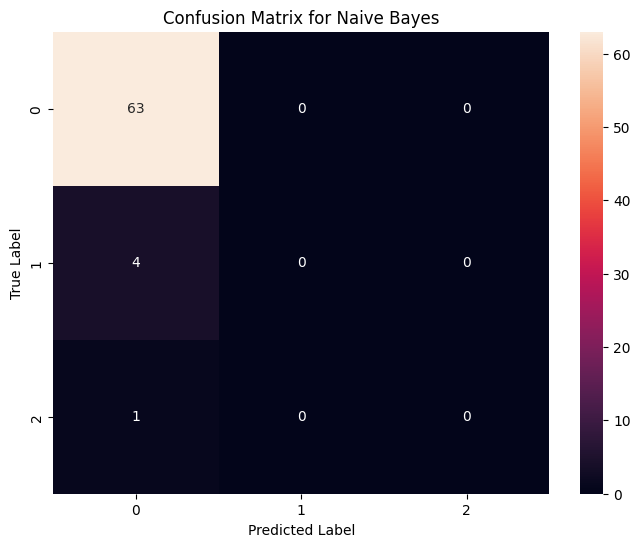

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Storing model performances
model_performances = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

# Function to train and evaluate models
def train_and_evaluate(classifiers, X_train, y_train, X_test, y_test):
    best_accuracy = best_precision = best_recall = best_f1_score = 0
    best_classifier = None
    best_classifier_name = None

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        print(f"{name} Accuracy: {accuracy}")
        print(f"{name} Precision: {precision}")
        print(f"{name} Recall: {recall}")
        print(f"{name} F1 Score: {f1}\n")

        model_performances['Model'].append(name)
        model_performances['Accuracy'].append(accuracy)
        model_performances['Precision'].append(precision)
        model_performances['Recall'].append(recall)
        model_performances['F1-Score'].append(f1)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_precision = precision
            best_recall = recall
            best_f1 = f1
            best_classifier = clf
            best_y_pred = y_pred
            best_classifier_name = name

        # Confusion matrix and classification report
        print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred)}")
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f'Confusion Matrix for {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    # Save the best model
    best_model_name = f"best_model_{best_classifier_name}.pkl"
    joblib.dump(best_classifier, best_model_name)
    return best_classifier, best_accuracy, best_precision, best_recall, best_f1, best_y_pred, clf.classes_

# Train, evaluate models
best_model = train_and_evaluate(classifiers, X_train, y_train, X_test, y_test)

Best Performing Model is:  RandomForestClassifier()
Accuracy: 0.9705882352941176
Precision: 0.9897435897435898
Recall: 0.8333333333333334
F1 Score: 0.8836805555555555

Classification Report for RandomForestClassifier():
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        63
           1       1.00      0.50      0.67         4
           2       1.00      1.00      1.00         1

    accuracy                           0.97        68
   macro avg       0.99      0.83      0.88        68
weighted avg       0.97      0.97      0.97        68



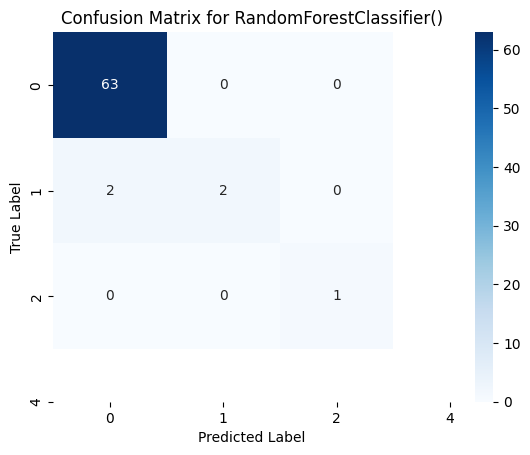

In [ ]:
#print which is the best model among them
print("Best Performing Model is: ", best_model[0])
print(f"Accuracy: {best_model[1]}")
print(f"Precision: {best_model[2]}")
print(f"Recall: {best_model[3]}")
print(f"F1 Score: {best_model[4]}\n")

# Confusion matrix and classification report for best model
print(f"Classification Report for {best_model[0]}:\n{classification_report(y_test, best_model[5])}")
cm = confusion_matrix(y_test, best_model[5])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model[6], yticklabels=best_model[6])
# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d')
plt.title(f'Confusion Matrix for {best_model[0]}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

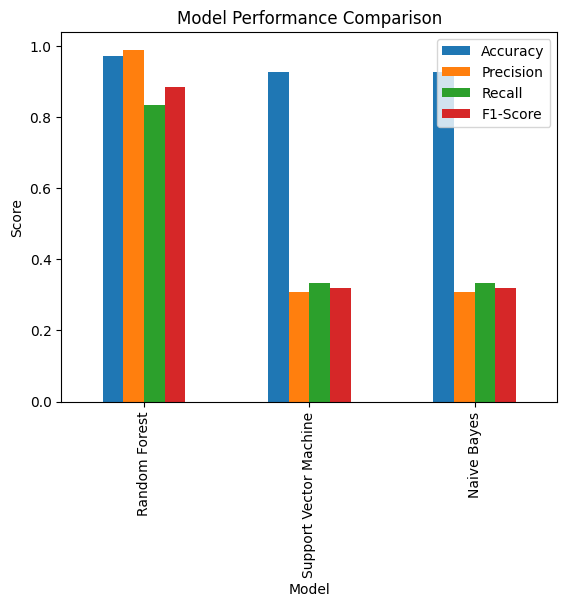

In [ ]:
# Plotting Model Perf. Comparison
performance_df = pd.DataFrame(model_performances)
performance_df.set_index('Model', inplace=True)
performance_df.plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.show()

In [ ]:
# Making sure 'Relevance' column is numeric and handling the errors using coercing the data
data_df['RELEVANCE'] = pd.to_numeric(data_df['RELEVANCE'], errors='coerce')

# Filtering out rows where 'Relevance' or 'Processed_Text' is NaN
filtered_data = data_df.dropna(subset=['RELEVANCE', 'Processed_Text'])

# Extracting features and labels
X_relevance = tfidf_vectorizer.transform(filtered_data['Processed_Text'])
y_relevance = filtered_data['RELEVANCE']

X_train_rel, X_test_rel, y_train_rel, y_test_rel = train_test_split(X_relevance, y_relevance, test_size=0.3, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

relevance_classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(random_state=42)
}

Random Forest Accuracy: 0.7864077669902912
Random Forest Precision: 0.2621359223300971
Random Forest Recall: 0.3333333333333333
Random Forest F1 Score: 0.2934782608695652

Classification Report for Random Forest:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.79      1.00      0.88        81
           3       0.00      0.00      0.00        10

    accuracy                           0.79       103
   macro avg       0.26      0.33      0.29       103
weighted avg       0.62      0.79      0.69       103



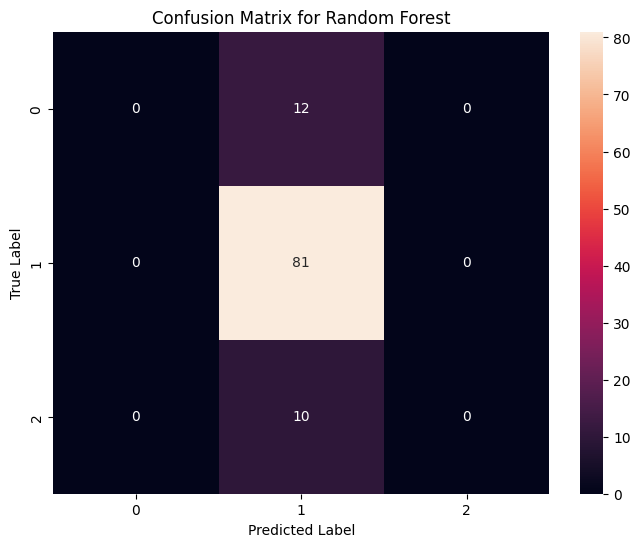

SVM Accuracy: 0.7864077669902912
SVM Precision: 0.2621359223300971
SVM Recall: 0.3333333333333333
SVM F1 Score: 0.2934782608695652

Classification Report for SVM:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.79      1.00      0.88        81
           3       0.00      0.00      0.00        10

    accuracy                           0.79       103
   macro avg       0.26      0.33      0.29       103
weighted avg       0.62      0.79      0.69       103



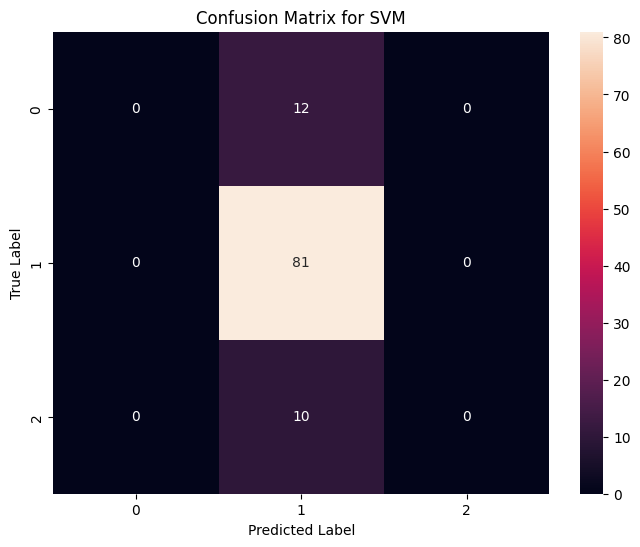

Naive Bayes Accuracy: 0.7864077669902912
Naive Bayes Precision: 0.2621359223300971
Naive Bayes Recall: 0.3333333333333333
Naive Bayes F1 Score: 0.2934782608695652

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.79      1.00      0.88        81
           3       0.00      0.00      0.00        10

    accuracy                           0.79       103
   macro avg       0.26      0.33      0.29       103
weighted avg       0.62      0.79      0.69       103



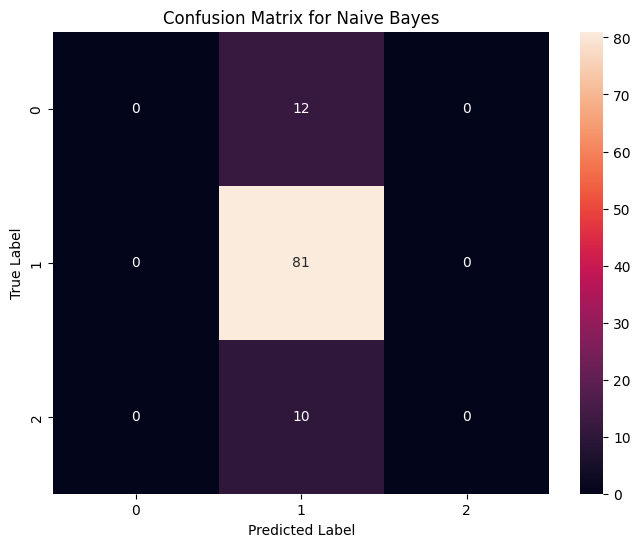

Logistic Regression Accuracy: 0.7864077669902912
Logistic Regression Precision: 0.2621359223300971
Logistic Regression Recall: 0.3333333333333333
Logistic Regression F1 Score: 0.2934782608695652

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.79      1.00      0.88        81
           3       0.00      0.00      0.00        10

    accuracy                           0.79       103
   macro avg       0.26      0.33      0.29       103
weighted avg       0.62      0.79      0.69       103



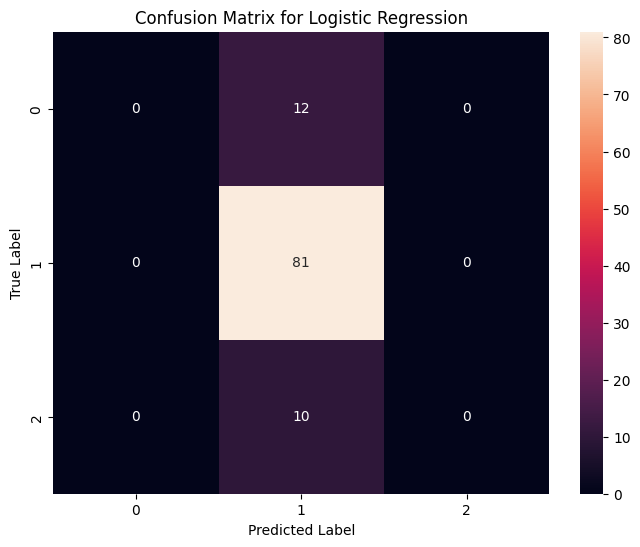

Best performing relevance prediction model: Random Forest with accuracy: 0.7864077669902912


['best_relevance_model_Random Forest.pkl']

In [ ]:
best_relevance_accuracy = 0
best_relevance_classifier = None
best_relevance_classifier_name = ""

# Storing model performances
relevance_model_performances = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

for name, clf in relevance_classifiers.items():
  clf.fit(X_train_rel, y_train_rel)
  y_pred_rel = clf.predict(X_test_rel)
  accuracy = accuracy_score(y_test_rel, y_pred_rel)
  precision = precision_score(y_test_rel, y_pred_rel, average='macro')
  recall = recall_score(y_test_rel, y_pred_rel, average='macro')
  f1 = f1_score(y_test_rel, y_pred_rel, average='macro')

  print(f"{name} Accuracy: {accuracy}")
  print(f"{name} Precision: {precision}")
  print(f"{name} Recall: {recall}")
  print(f"{name} F1 Score: {f1}\n")

  relevance_model_performances['Model'].append(name)
  relevance_model_performances['Accuracy'].append(accuracy)
  relevance_model_performances['Precision'].append(precision)
  relevance_model_performances['Recall'].append(recall)
  relevance_model_performances['F1-Score'].append(f1)

  if accuracy > best_relevance_accuracy:
      best_relevance_accuracy = accuracy
      best_relevance_classifier = clf
      best_relevance_classifier_name = name

  # Classification report and confusion matrix
  print(f"Classification Report for {name}:\n{classification_report(y_test_rel, y_pred_rel)}")
  cm = confusion_matrix(y_test_rel, y_pred_rel)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title(f'Confusion Matrix for {name}')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

print(f"Best performing relevance prediction model: {best_relevance_classifier_name} with accuracy: {best_relevance_accuracy}")

# Saving the best relevance classification model
best_model_filename = f"best_relevance_model_{best_relevance_classifier_name}.pkl"
joblib.dump(best_relevance_classifier, best_model_filename)

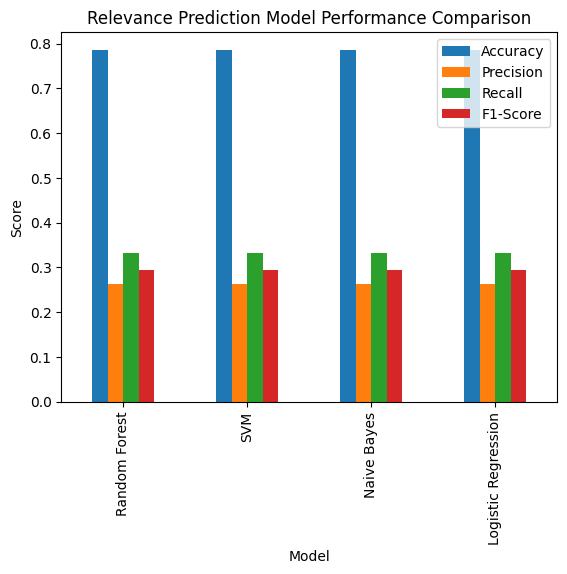

In [ ]:
# Plotting Model Perf. Comparison
performance_df = pd.DataFrame(relevance_model_performances)
performance_df.set_index('Model', inplace=True)
performance_df.plot(kind='bar')
plt.title('Relevance Prediction Model Performance Comparison')
plt.ylabel('Score')
plt.show()